In [1]:
from gym.spaces import Tuple, Discrete, Box
from pycigar.utils.input_parser import input_parser
import pycigar
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
from pycigar.utils.logging import logger
from pycigar.utils.output import plot_new

from ray.tune.registry import register_env

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import json
from pathlib import Path
from ray.rllib.models.catalog import ModelCatalog
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from pathlib import Path

from pycigar.utils.input_parser import input_parser
misc_inputs = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata/misc_inputs.csv'
dss = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata/ieee37.dss'
load_solar = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata/load_solar_data.csv'
breakpoints = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata/breakpoints.csv'
#best_dir = Path('/home/toanngo/final_oscillation_results_discrete_eval_35_random_reg_no_max/final_results_discrete_eval_30_random_reg_no_max/main/run_train/run_train_0_T=2,M=50000,N=50,P=60,lr=0.0001_2020-09-16_22-45-03nu6061l6/best/reward_sum/policy_800')
best_dir_1 = Path('/home/toanngo/new_baseline_37_multi/main/run_train/run_train_0_lr=0.001_2020-10-23_01-41-19iw4l8k1t/best/policy_900/agent_1') # current u, step=30
best_dir_2 = Path('/home/toanngo/new_baseline_37_multi/main/run_train/run_train_0_lr=0.001_2020-10-23_01-41-19iw4l8k1t/best/policy_900/agent_2')
best_dir_3 = Path('/home/toanngo/new_baseline_37_multi/main/run_train/run_train_0_lr=0.001_2020-10-23_01-41-19iw4l8k1t/best/policy_900/agent_3')

start = 100
sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, vectorized_mode=True, percentage_hack=0.2)
sim_params['scenario_config']['start_end_time'] = [start, start + 750]
sim_params['env_config']['sim_per_step'] = 30
del sim_params['attack_randomization']
sim_params['cluster'] = {'1': ['s701a', 's701b', 's701c', 's712c', 's713c', 's714a', 's714b', 's718a', 's720c', 's722b', 's722c', 's724b', 's725b'],
                         '2': ['s727c', 's728', 's729a', 's730c', 's731b', 's732c', 's733a'],
                         '3': ['s734c', 's735c', 's736b', 's737a', 's738a', 's740c', 's741c', 's742a', 's742b', 's744a']
                        }
policy = tf.saved_model.load(str(best_dir_1))
infer_1 = policy.signatures['serving_default']

policy = tf.saved_model.load(str(best_dir_2))
infer_2 = policy.signatures['serving_default']

policy = tf.saved_model.load(str(best_dir_3))
infer_3 = policy.signatures['serving_default']

action_dist, _ = ModelCatalog.get_action_dist(
    Tuple([Discrete(21)] * 3), config={}, dist_type=None, framework='tf')

from pycigar.envs.multiagent.multi_envs import ClusterMultiEnv

env = ClusterMultiEnv(sim_params=sim_params)
obs = env.reset()
done = False
while not done:
    all_act = {}
    out_1 = infer_1(
        prev_reward=tf.constant([0.], tf.float32),
        observations=tf.constant([obs['1']], tf.float32),
        is_training=tf.constant(False),
        seq_lens=tf.constant([0], tf.int32),
        prev_action=tf.constant([0], tf.int64)
    )['action_dist_inputs'].numpy()
    dist = action_dist(inputs=out_1, model=None)
    #act = dist.deterministic_sample().numpy().batches
    act = np.array(dist.deterministic_sample()).flatten()
    all_act['1'] = act
    
    out_2 = infer_2(
        prev_reward=tf.constant([0.], tf.float32),
        observations=tf.constant([obs['2']], tf.float32),
        is_training=tf.constant(False),
        seq_lens=tf.constant([0], tf.int32),
        prev_action=tf.constant([0], tf.int64)
    )['action_dist_inputs'].numpy()
    dist = action_dist(inputs=out_2, model=None)
    #act = dist.deterministic_sample().numpy().batches
    act = np.array(dist.deterministic_sample()).flatten()
    all_act['2'] = act

    out_3 = infer_3(
        prev_reward=tf.constant([0.], tf.float32),
        observations=tf.constant([obs['3']], tf.float32),
        is_training=tf.constant(False),
        seq_lens=tf.constant([0], tf.int32),
        prev_action=tf.constant([0], tf.int64)
    )['action_dist_inputs'].numpy()
    dist = action_dist(inputs=out_3, model=None)
    #act = dist.deterministic_sample().numpy().batches
    act = np.array(dist.deterministic_sample()).flatten()
    all_act['3'] = act
    obs, r, done, _ = env.step(all_act)
    done = done['__all__']

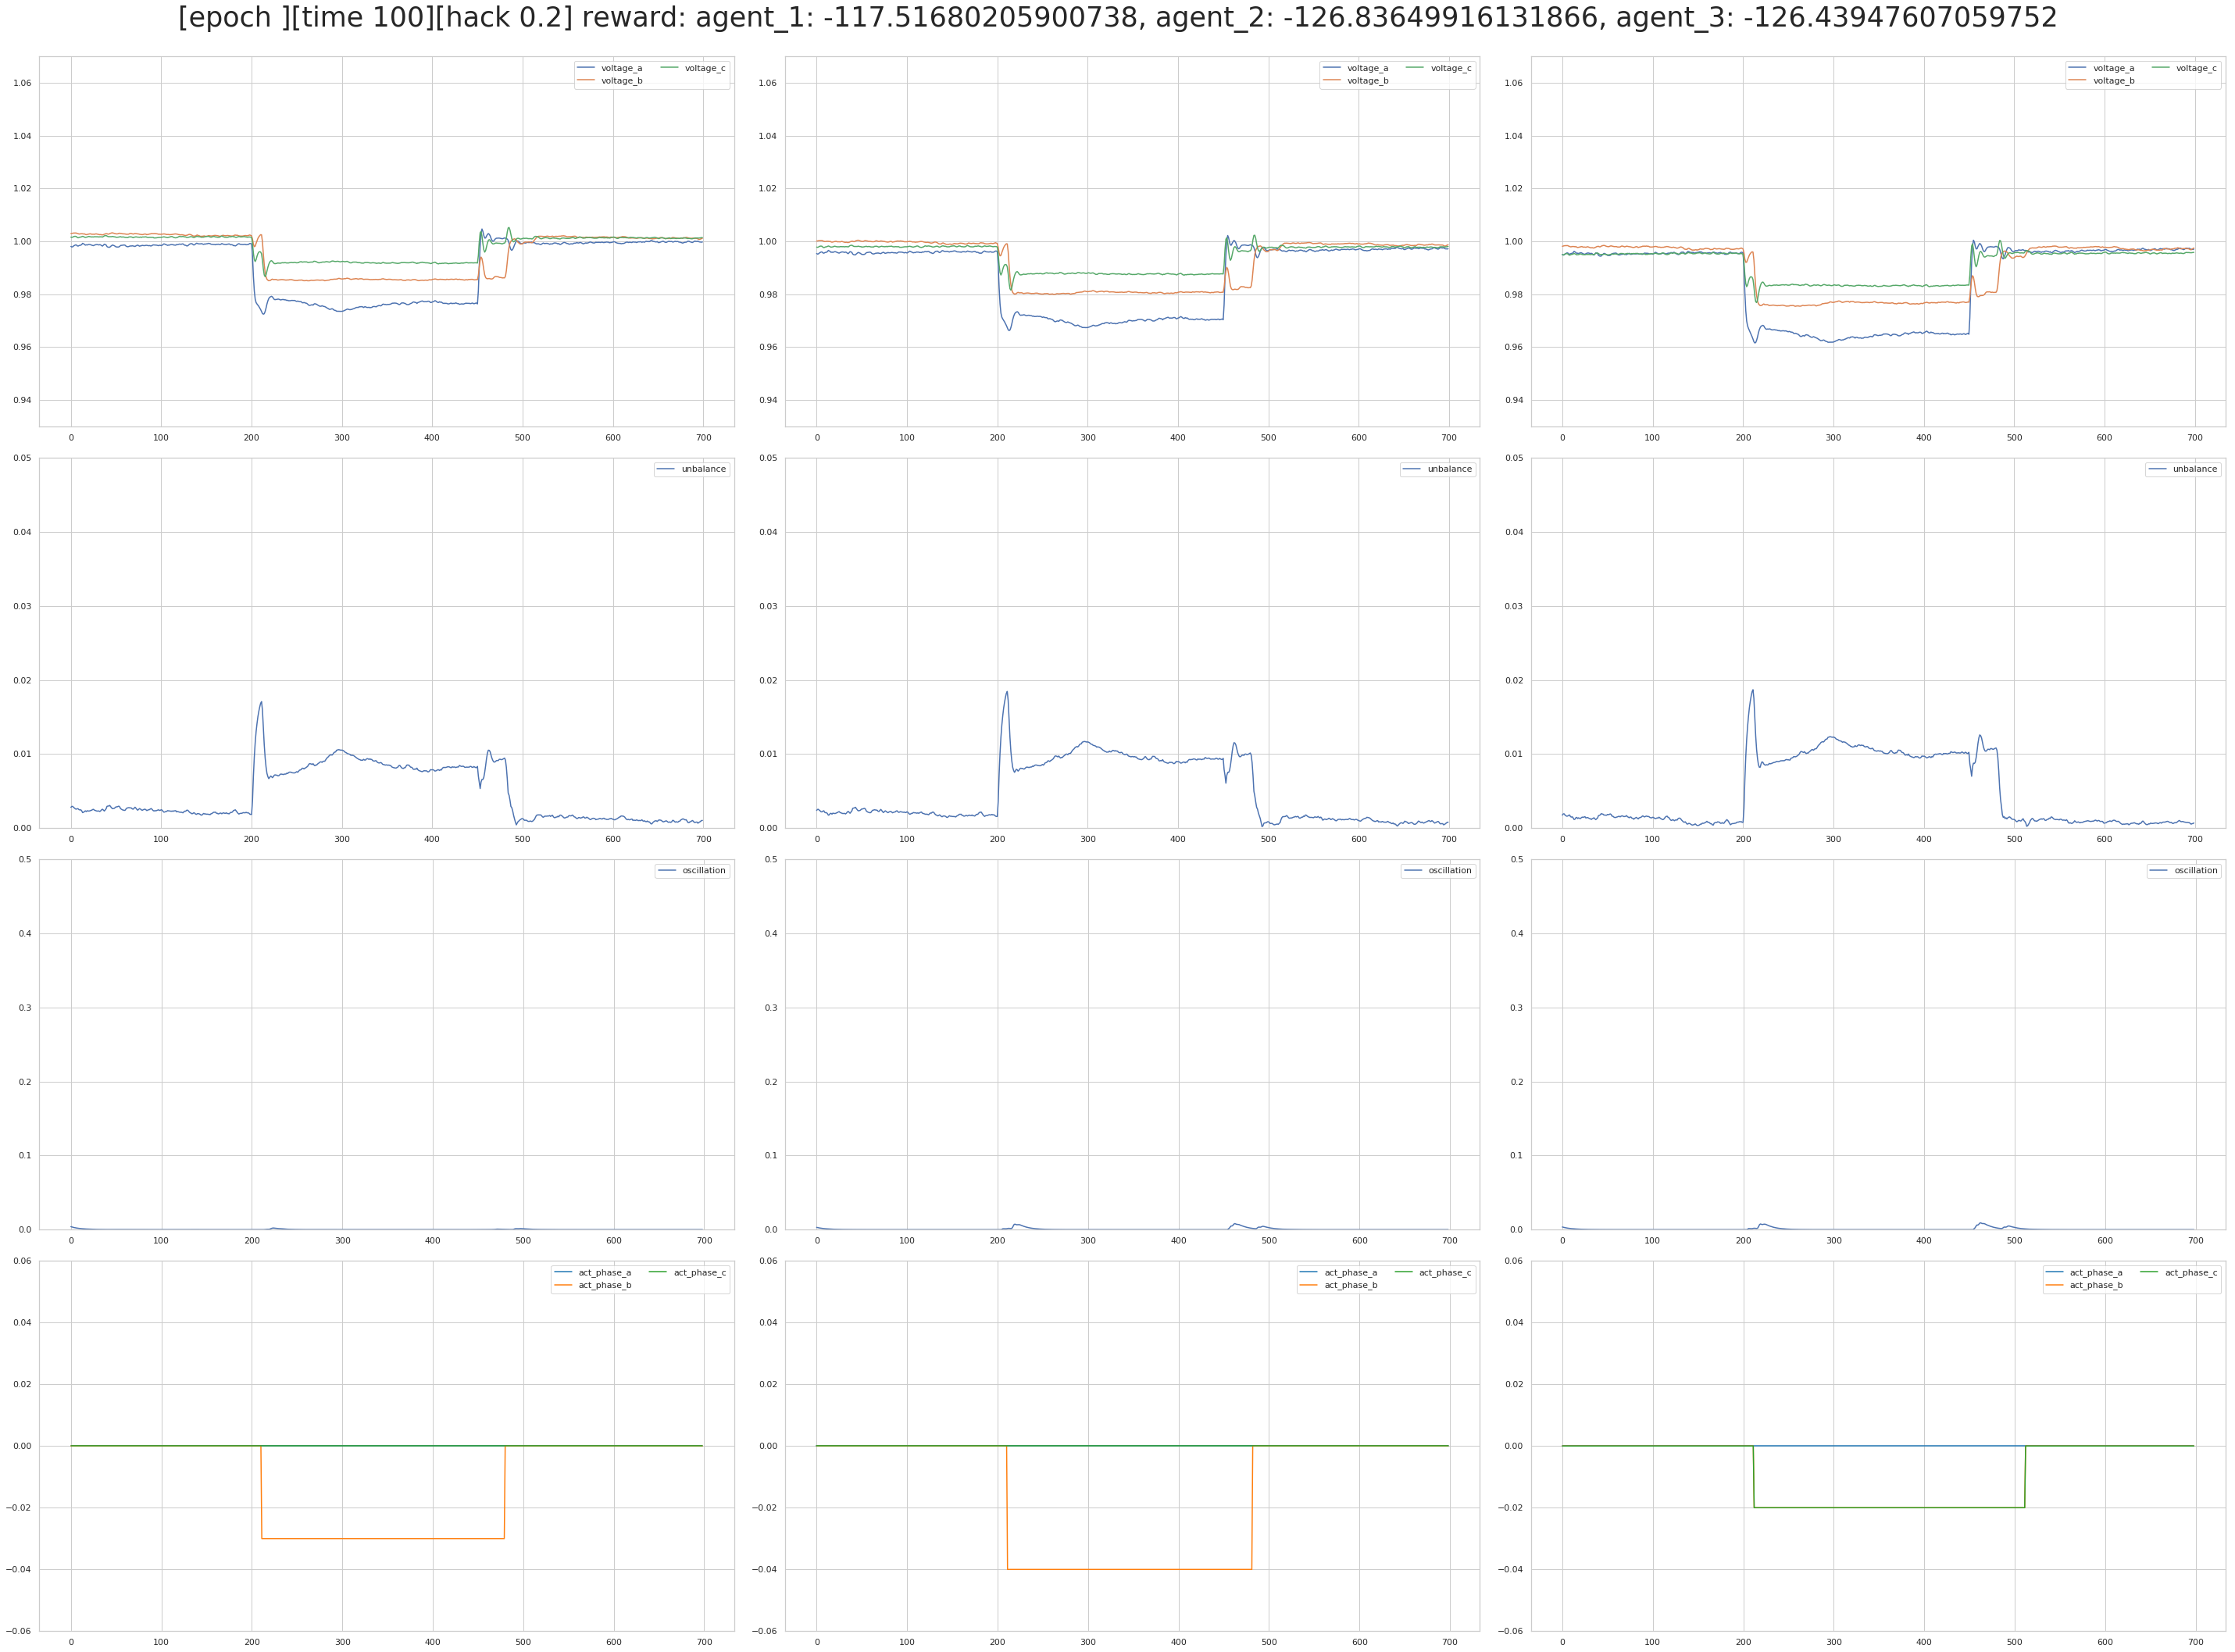

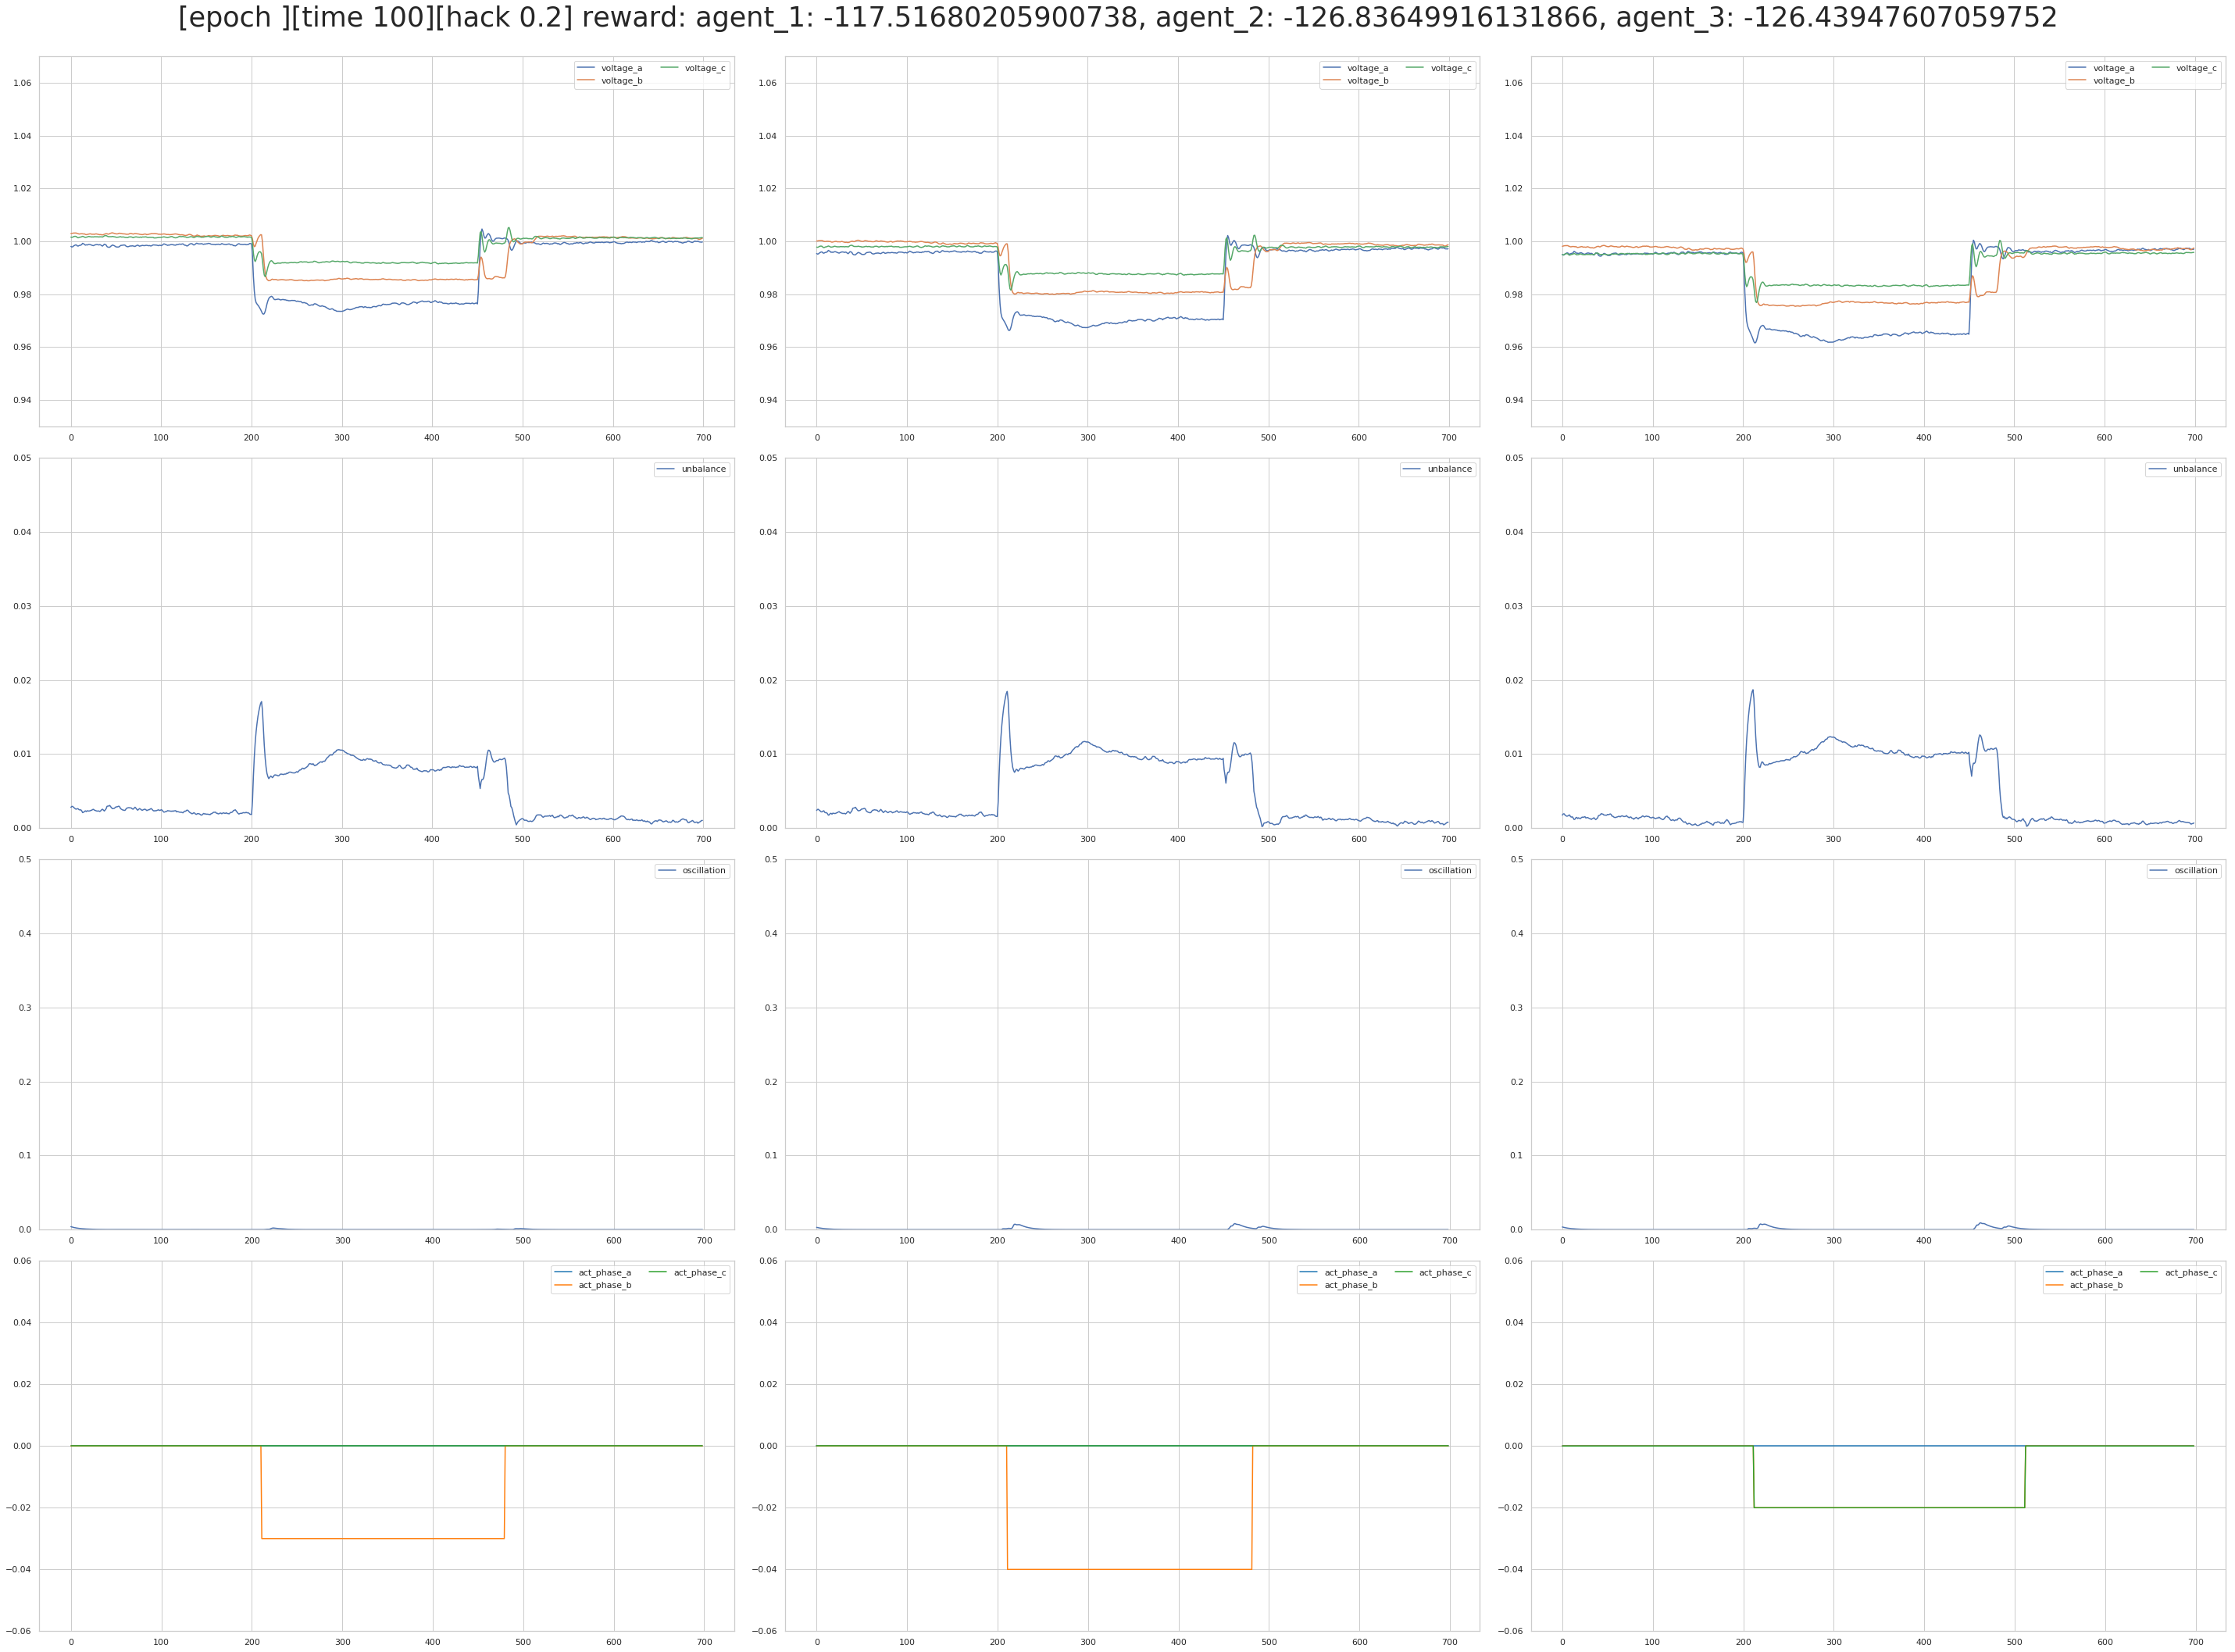

In [2]:
from pycigar.utils.logging import logger
from pycigar.utils.output import plot_cluster

log_dict = logger().log_dict
custom_metrics = logger().custom_metrics
plot_cluster(log_dict, custom_metrics, epoch='', unbalance=False, multiagent=False)

In [1]:
from pycigar.utils.input_parser import input_parser

misc_inputs = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata_regulator_attack/misc_inputs.csv'
dss = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata_regulator_attack/ieee37.dss'
load_solar = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata_regulator_attack/load_solar_data.csv'
breakpoints = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata_regulator_attack/breakpoints.csv'

start = 100
sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, vectorized_mode=True, percentage_hack=0.3)
sim_params['scenario_config']['start_end_time'] = [start, start + 750]
sim_params['cluster'] = {'1': ['s701a', 's701b', 's701c', 's712c', 's713c', 's714a', 's714b', 's718a', 's720c', 's722b', 's722c', 's724b', 's725b'],
                         '2': ['s727c', 's728', 's729a', 's730c', 's731b', 's732c', 's733a'],
                         '3': ['s734c', 's735c', 's736b', 's737a', 's738a', 's740c', 's741c', 's742a', 's742b', 's744a']
                            }
for node in sim_params['scenario_config']['nodes']:
    for d in node['devices']:
        d['adversary_controller'] = 'unbalanced_fixed_controller'

del sim_params['attack_randomization']

from pycigar.envs.multiagent.multi_envs import ClusterMultiEnv

env = ClusterMultiEnv(sim_params=sim_params)
obs = env.reset()
done = False
total_r = 0
while not done:
    obs, r, done, info = env.step({'1':[10, 10, 10], '2':[10, 10, 10], '3':[10, 10, 10]})
    done = done['__all__']

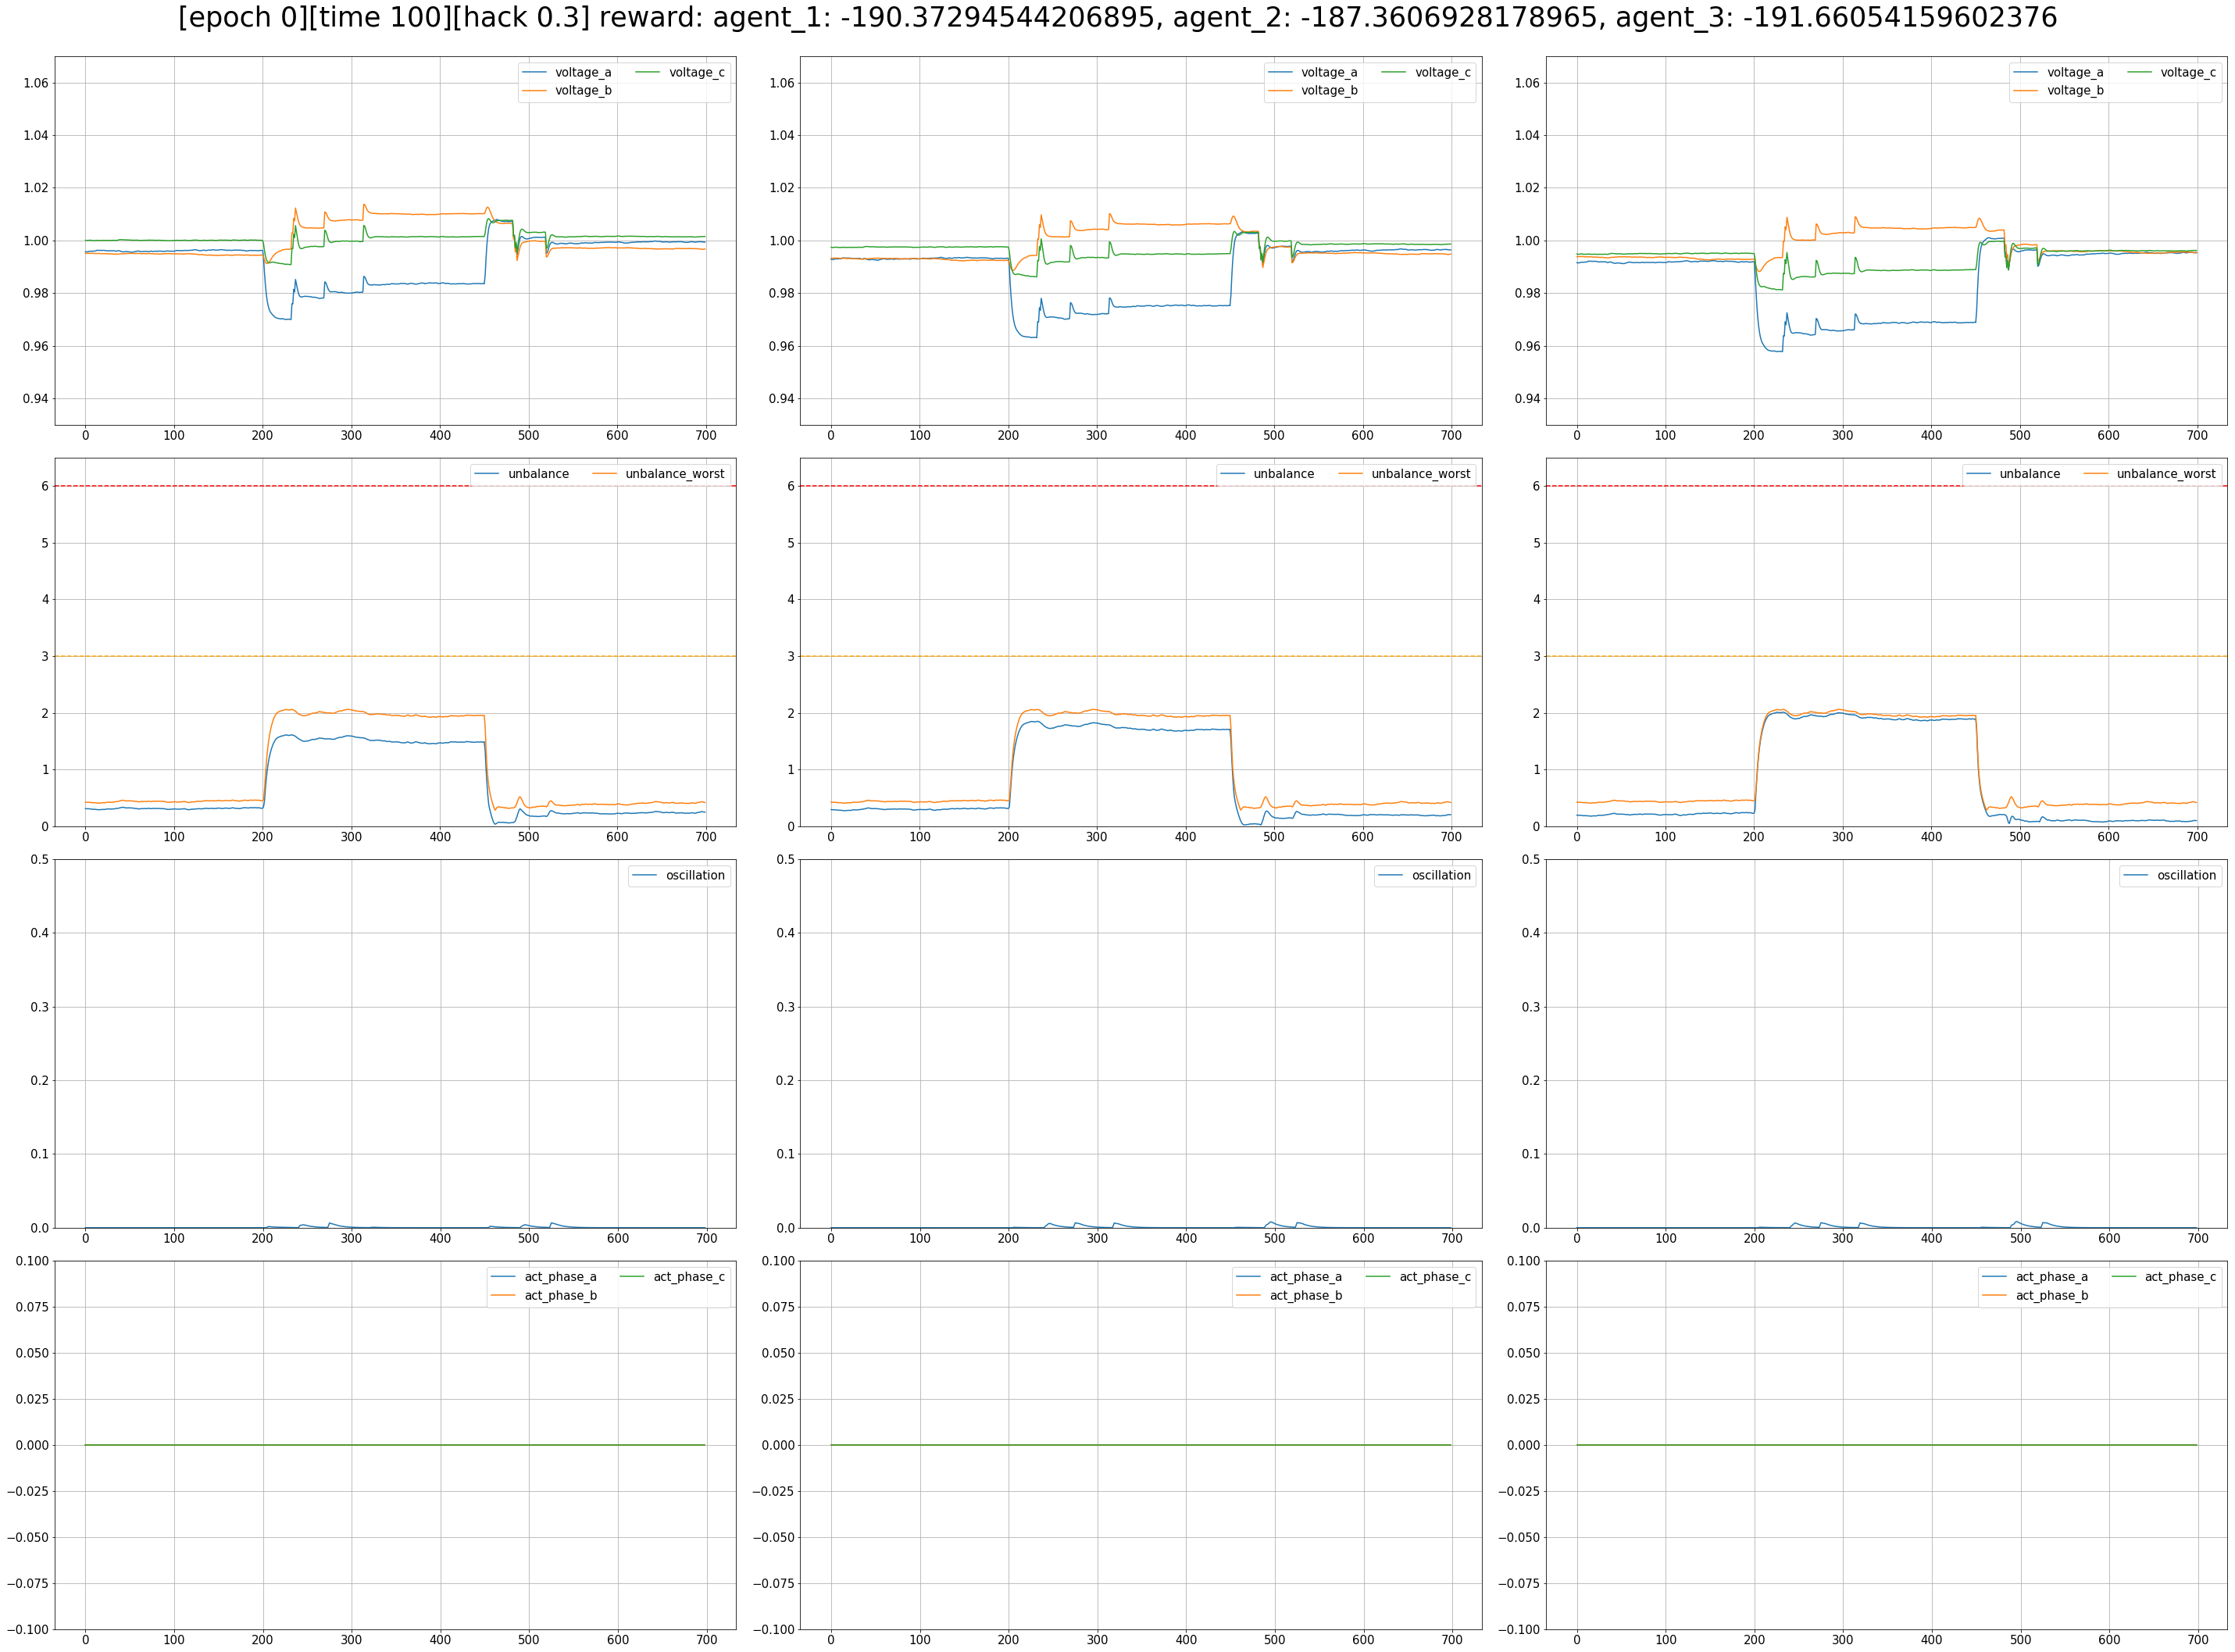

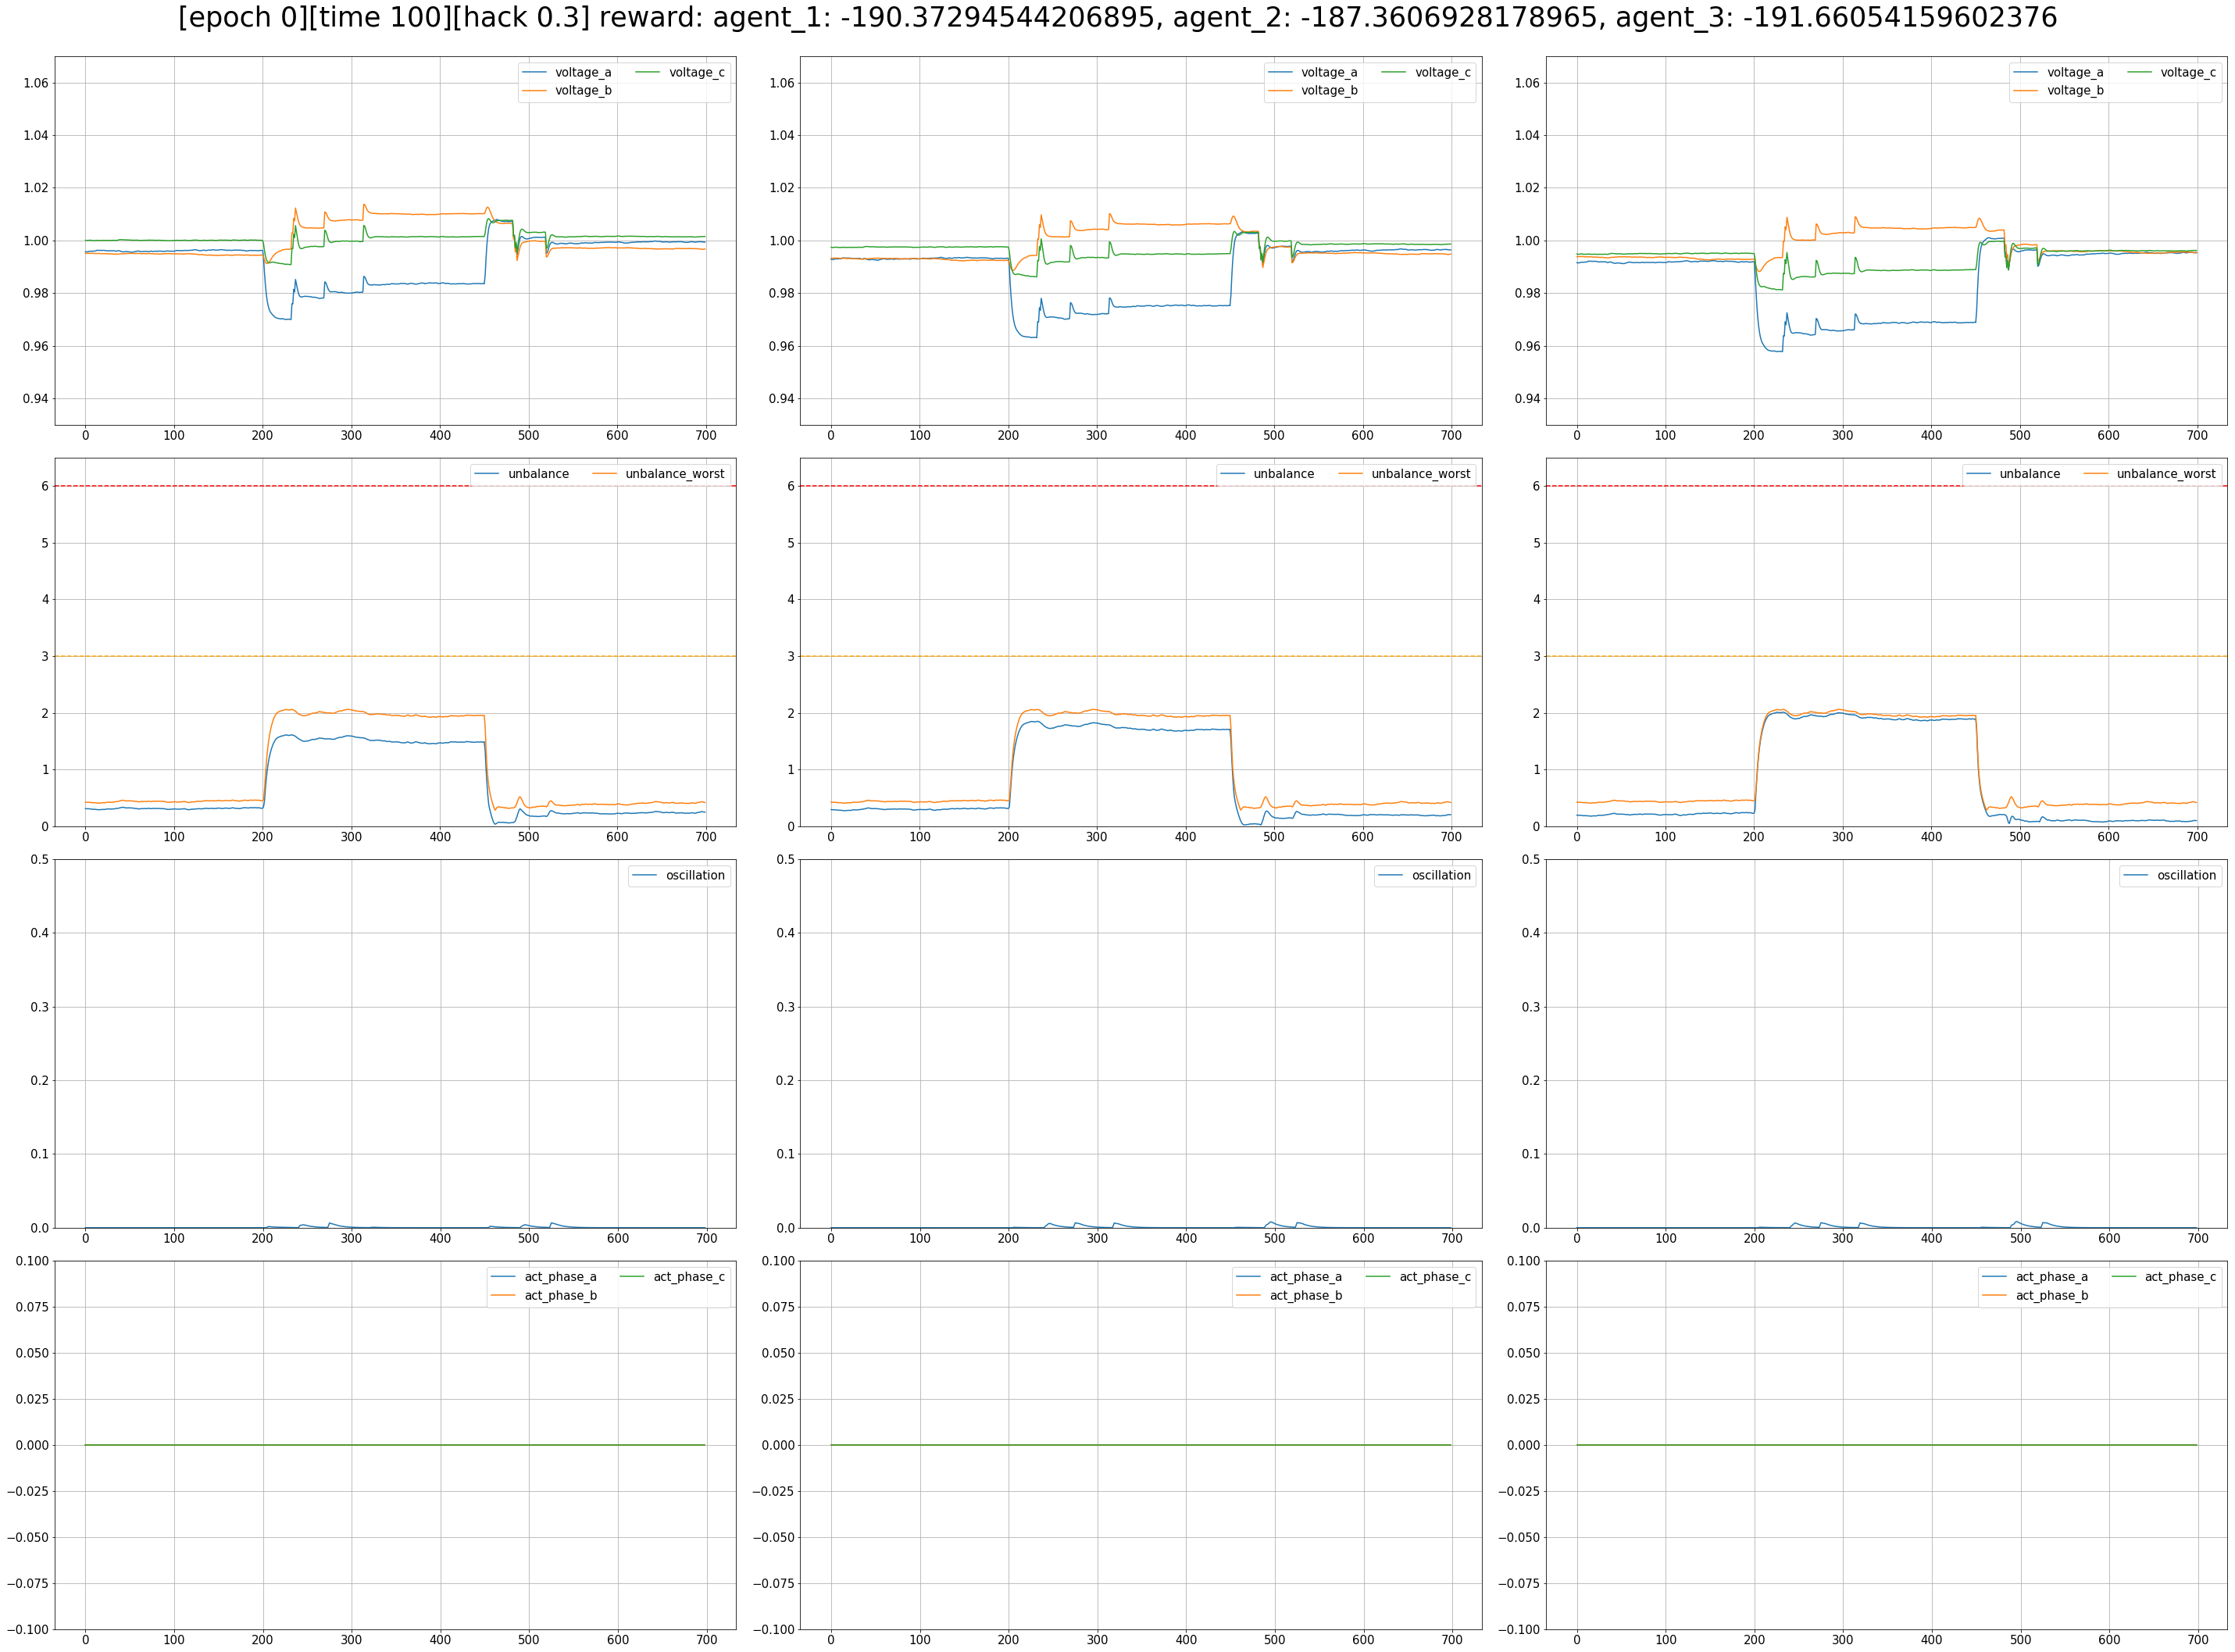

In [2]:
from pycigar.utils.output import plot_cluster
from pycigar.utils.logging import logger


plot_cluster(logger().log_dict, logger().custom_metrics, 0, True)

In [3]:
logger().log_dict.keys()

dict_keys(['inverter_s701a', 'inverter_s701b', 'inverter_s701c', 'inverter_s712c', 'inverter_s713c', 'inverter_s714a', 'inverter_s714b', 'inverter_s718a', 'inverter_s720c', 'inverter_s722b', 'inverter_s722c', 'inverter_s724b', 'inverter_s725b', 'inverter_s727c', 'inverter_s728', 'inverter_s729a', 'inverter_s730c', 'inverter_s731b', 'inverter_s732c', 'inverter_s733a', 'inverter_s734c', 'inverter_s735c', 'inverter_s736b', 'inverter_s737a', 'inverter_s738a', 'inverter_s740c', 'inverter_s741c', 'inverter_s742a', 'inverter_s742b', 'inverter_s744a', 'u_metrics', 'adversary_inverter_s701a', 'adversary_inverter_s701b', 'adversary_inverter_s701c', 'adversary_inverter_s712c', 'adversary_inverter_s713c', 'adversary_inverter_s714a', 'adversary_inverter_s714b', 'adversary_inverter_s718a', 'adversary_inverter_s720c', 'adversary_inverter_s722b', 'adversary_inverter_s722c', 'adversary_inverter_s724b', 'adversary_inverter_s725b', 'adversary_inverter_s727c', 'adversary_inverter_s728', 'adversary_inverte